In [1]:
import os


In [2]:
import torch
import numpy as np
from data import Task1Data, Task2Data, Task3Data
import os
import statsmodels.api as sm
import matplotlib.pyplot as plt

In [3]:
norm_dataset = Task1Data()
abide_dataset = Task2Data()
mci_dataset = Task3Data(no=2)
ad_dataset = Task3Data(no=1)


(712, 62, 2) (712,) (712,)
(999, 62, 2) (999,) (999,)
(649, 62, 2) (649,) (649,)
Finding files: 2360/2360/2360
Finding files: 1031/1031/1031
Finding files: 712/712/712
380/332
Finding files: 604/604/604
272/332


In [362]:
sex_0_mean = np.zeros((100,62))
sex_0_std = np.zeros((100,62))
sex_1_mean = np.zeros((100,62))
sex_1_std = np.zeros((100,62))

In [363]:
# name = 'res/mask_bugfix8_claude_schedule_norm5/'
# name = 'res/mask_bugfix8_claude_schedule_norm5_rerun//'
# name = 'res/mask_addSP_run3_reweightscale/'
name = 'res/mask_addSP_run7_soft_spl_ft//'

for sex in range(2):
    for age in range(100):
        dat = np.load(f"{name}//sex-{sex}_age-{age}.npy")
        if sex == 0:
            sex_0_mean[age] = dat.mean(0).reshape(-1)[:62]
            sex_0_std[age] = dat.std(0).reshape(-1)[:62]
        else:
            sex_1_mean[age] = dat.mean(0).reshape(-1)[:62]
            sex_1_std[age] = dat.std(0).reshape(-1)[:62]

In [364]:
mean_training_data_sex_0 = np.zeros((100,62))
mean_training_data_sex_1 = np.zeros((100,62))

for sex in range(2):
    for age in range(100):
        if sex == 0:
            mean_training_data_sex_0[age] = norm_dataset.ct_feas[(norm_dataset.sexs==0) & (norm_dataset.ages==age)][...,0].mean(0).reshape(-1)[:62]
        else:
            mean_training_data_sex_1[age] = norm_dataset.ct_feas[(norm_dataset.sexs==1) & (norm_dataset.ages==age)][...,0].mean(0).reshape(-1)[:62]
            

ours: 0.035 gpr: 0.034


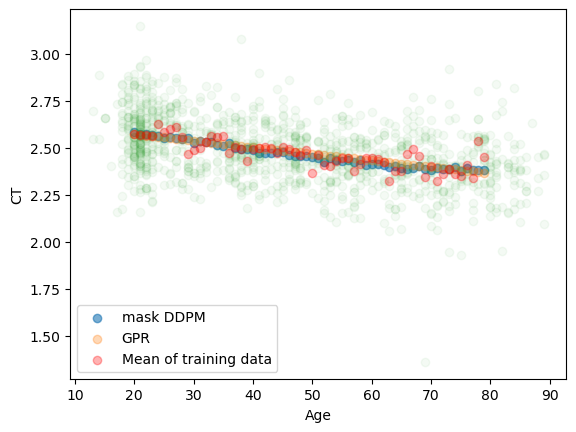

In [365]:
roi = 0
st=20
end = 80
x_constant = sm.add_constant(norm_dataset.ages[norm_dataset.sexs==0].reshape(-1,1))
model = sm.GLM(norm_dataset.ct_feas[:,roi,0][norm_dataset.sexs==0].reshape(-1,1), x_constant, family=sm.families.Gaussian())
results = model.fit()
pred = results.predict(sm.add_constant(np.array(range(100)).reshape(-1,1)))

plt.scatter(range(100)[st:end], (sex_0_mean[st:end,roi] + 0) / 1 * 5, label = 'mask DDPM',alpha=0.6)
plt.scatter(range(100)[st:end], pred[st:end] * 5, label = 'GPR',alpha=0.3)
plt.scatter(norm_dataset.ages[norm_dataset.sexs==0].reshape(-1),norm_dataset.ct_feas[:,roi,0][norm_dataset.sexs==0]*5,alpha=0.05)
plt.scatter(range(100)[st:end], mean_training_data_sex_0[st:end,roi]*5,alpha=0.3,color='red',label='Mean of training data')
error_mask =  np.abs(mean_training_data_sex_0[st:end,roi]*5 - (sex_0_mean[st:end,roi] + 0) / 1 * 5).mean()
error_gpr =  np.abs(pred[st:end] * 5 - mean_training_data_sex_0[st:end,roi]*5).mean()
print(f"ours: {error_mask:.3f} gpr: {error_gpr:.3f}")
plt.xlabel("Age")
plt.ylabel("CT")
plt.legend()

ours: 0.027 gpr: 0.029


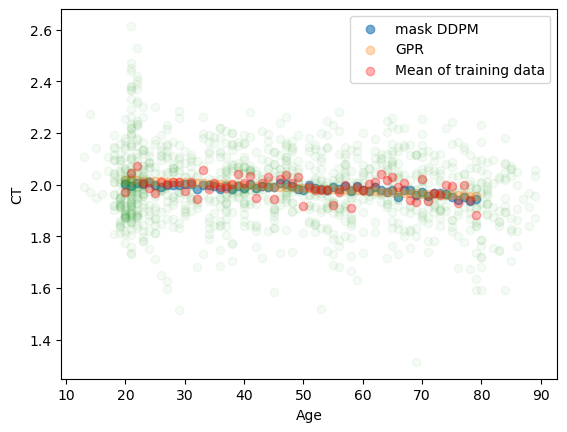

In [366]:
roi = 10
st=20
end = 80
x_constant = sm.add_constant(norm_dataset.ages[norm_dataset.sexs==0].reshape(-1,1))
model = sm.GLM(norm_dataset.ct_feas[:,roi,0][norm_dataset.sexs==0].reshape(-1,1), x_constant, family=sm.families.Gaussian())
results = model.fit()
pred = results.predict(sm.add_constant(np.array(range(100)).reshape(-1,1)))

plt.scatter(range(100)[st:end], (sex_0_mean[st:end,roi] + 0) / 1 * 5, label = 'mask DDPM',alpha=0.6)
plt.scatter(range(100)[st:end], pred[st:end] * 5, label = 'GPR',alpha=0.3)
plt.scatter(norm_dataset.ages[norm_dataset.sexs==0].reshape(-1),norm_dataset.ct_feas[:,roi,0][norm_dataset.sexs==0]*5,alpha=0.05)
plt.scatter(range(100)[st:end], mean_training_data_sex_0[st:end,roi]*5,alpha=0.3,color='red',label='Mean of training data')
error_mask =  np.abs(mean_training_data_sex_0[st:end,roi]*5 - (sex_0_mean[st:end,roi] + 0) / 1 * 5).mean()
error_gpr =  np.abs(pred[st:end] * 5 - mean_training_data_sex_0[st:end,roi]*5).mean()
print(f"ours: {error_mask:.3f} gpr: {error_gpr:.3f}")
plt.xlabel("Age")
plt.ylabel("CT")
plt.legend()

In [367]:
ours_errors = []
gpr_errors = []
for sex in range(2):
    for roi in range(62):
        x_constant = sm.add_constant(norm_dataset.ages[norm_dataset.sexs==sex].reshape(-1,1))
        model = sm.GLM(norm_dataset.ct_feas[:,roi,0][norm_dataset.sexs==sex].reshape(-1,1), x_constant, family=sm.families.Gaussian())
        results = model.fit()
        pred = results.predict(sm.add_constant(np.array(range(100)).reshape(-1,1)))

        if sex == 0:
            mean_val = mean_training_data_sex_0
            mine_mean = sex_0_mean
        else:
            mean_val = mean_training_data_sex_1
            mine_mean = sex_1_mean
        # error_mask =  ((mean_val[st:end,roi]*5 - (mine_mean[st:end,roi] + 0) / 1 * 5) ** 2).mean()
        error_mask =  (np.abs(mean_val[st:end,roi]*5 - (mine_mean[st:end,roi] + 0) / 1 * 5)).mean()
        # error_gpr =  ((pred[st:end] * 5 - mean_val[st:end,roi]*5)**2).mean()
        error_gpr =  (np.abs(pred[st:end] * 5 - mean_val[st:end,roi]*5)).mean()
        # print(f"{sex}-{roi} ours: {error_mask:.3f} gpr: {error_gpr:.3f}")
        ours_errors.append(error_mask)
        gpr_errors.append(error_gpr)

print(f"ours:{np.mean(ours_errors)} gpr:{np.mean(gpr_errors)}")

ours:0.03525122753814933 gpr:0.03695854151813905


In [ ]:
#no mask: ours:0.03506465756656713 gpr:0.0369585415181390  mask_addSP_run4_mask0_noSPL
#add mask and spl: ours:0.03436380549917356 gpr:0.03695854151813905  mask_addSP_run3_reweightscale
#no SPL:  ours:0.03412961928298507 gpr:0.03695854151813905 mask_bugfix8_claude_schedule_norm5
# ours:0.03592904081175562 gpr:0.03695854151813905
# run6 ours:0.03469599081494177 gpr:0.03695854151813905
# ours:0.034671112879642536 gpr:0.03695854151813905

In [368]:
(0.03412961928298507 - 0.03695854151813905)/0.03695854151813905

-0.07654312424005037

In [316]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

In [317]:
use_feas = abide_dataset.ct_feas[:,:,0] / 5
use_age = abide_dataset.ages
use_sex = abide_dataset.sexs
use_dx = abide_dataset.dx

mine_feas = np.zeros_like(use_feas)
for i in range(len(use_feas)):
    if use_sex[i] == 0:
        mean = sex_0_mean[use_age[i]]
        var = sex_0_std[use_age[i]]
        mine_feas[i] = (use_feas[i] - mean) / var
    elif use_sex[i] == 1:
        mean = sex_1_mean[use_age[i]]
        var = sex_1_std[use_age[i]]
        mine_feas[i] = (use_feas[i] - mean) / var
    else:
        print("error")

In [318]:
svm1 = SVC()
svm2 = SVC()

pipeline = make_pipeline(svm1)
X = use_feas.reshape((len(use_feas), -1))
y = use_dx
# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# 计算交叉验证的分数
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy')

# 输出每折的得分和平均分
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

print("*" * 40)
X2 = mine_feas
y = use_dx
# pipeline2 = make_pipeline(svm)
pipeline2 = make_pipeline(svm2)

scores2 = cross_val_score(pipeline2, X2, y, cv=kf, scoring='accuracy')
# 输出每折的得分和平均分
print(f"Cross-validation scores: {scores2}")
print(f"Mean accuracy: {scores2.mean():.2f}")

Cross-validation scores: [0.55072464 0.46601942 0.51941748 0.52427184 0.56796117]
Mean accuracy: 0.53
****************************************
Cross-validation scores: [0.58454106 0.49029126 0.51941748 0.54368932 0.53398058]
Mean accuracy: 0.53


In [319]:
use_feas = mci_dataset.ct_feas[:,:,0] / 5
use_age = mci_dataset.ages
use_sex = mci_dataset.sexs
use_dx = mci_dataset.dx

mine_feas = np.zeros_like(use_feas)
for i in range(len(use_feas)):
    if use_sex[i] == 0:
        mean = sex_0_mean[use_age[i]]
        var = sex_0_std[use_age[i]]
        mine_feas[i] = (use_feas[i] - mean) / var
    elif use_sex[i] == 1:
        mean = sex_1_mean[use_age[i]]
        var = sex_1_std[use_age[i]]
        mine_feas[i] = (use_feas[i] - mean) / var
    else:
        print("error")

In [320]:
svm1 = SVC()
svm2 = SVC()

pipeline = make_pipeline(StandardScaler(), svm1)
X = use_feas.reshape((len(use_feas), -1))
y = use_dx
# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=42)

# 计算交叉验证的分数
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy')

# 输出每折的得分和平均分
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

print("*" * 40)
X2 = mine_feas
y = use_dx
pipeline2 = make_pipeline(StandardScaler(),svm2)

scores2 = cross_val_score(pipeline2, X2, y, cv=kf, scoring='accuracy')

# 输出每折的得分和平均分
print(f"Cross-validation scores: {scores2}")
print(f"Mean accuracy: {scores2.mean():.2f}")

Cross-validation scores: [0.58041958 0.53846154 0.59859155 0.55633803 0.56338028]
Mean accuracy: 0.57
****************************************
Cross-validation scores: [0.62937063 0.57342657 0.61971831 0.58450704 0.61267606]
Mean accuracy: 0.60


In [321]:
use_feas = ad_dataset.ct_feas[:,:,0] / 5
use_age = ad_dataset.ages
use_sex = ad_dataset.sexs
use_dx = ad_dataset.dx
mine_feas = np.zeros_like(use_feas)
for i in range(len(use_feas)):
    if use_sex[i] == 0:
        mean = sex_0_mean[use_age[i]]
        var = sex_0_std[use_age[i]]
        mine_feas[i] = (use_feas[i] - mean) / var
    elif use_sex[i] == 1:
        mean = sex_1_mean[use_age[i]]
        var = sex_1_std[use_age[i]]
        mine_feas[i] = (use_feas[i] - mean) / var
    else:
        print("error")

In [322]:
svm1 = SVC()
svm2 = SVC()

pipeline = make_pipeline(StandardScaler(), svm1)
X = use_feas.reshape((len(use_feas), -1))
y = use_dx
# 设置5折交叉验证
kf = KFold(n_splits=5, shuffle=True, random_state=8)

# 计算交叉验证的分数
scores = cross_val_score(pipeline, X, y, cv=kf, scoring='accuracy')

# 输出每折的得分和平均分
print(f"Cross-validation scores: {scores}")
print(f"Mean accuracy: {scores.mean():.2f}")

print("*" * 40)
X2 = mine_feas
y = use_dx
pipeline2 = make_pipeline(StandardScaler(),svm2)
scores2 = cross_val_score(pipeline2, X2, y, cv=kf, scoring='accuracy')
# 输出每折的得分和平均分
print(f"Cross-validation scores: {scores2}")
print(f"Mean accuracy: {scores2.mean():.2f}")

Cross-validation scores: [0.84297521 0.82644628 0.89256198 0.91735537 0.93333333]
Mean accuracy: 0.88
****************************************
Cross-validation scores: [0.85950413 0.83471074 0.90082645 0.92561983 0.91666667]
Mean accuracy: 0.89


In [274]:
age=12
sex=0

In [235]:
dat = np.load(f"{name}//sex-{sex}_age-{age}.npy")

(0.4, 0.7)

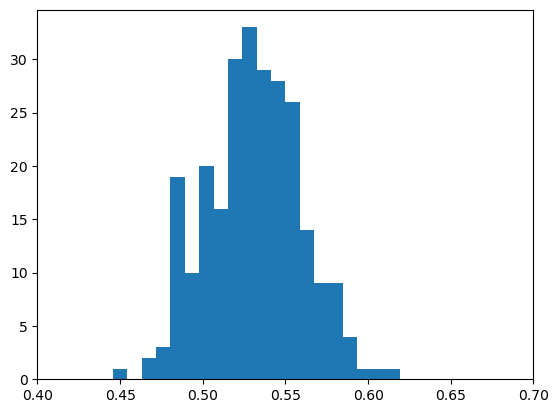

In [236]:
plt.hist(dat[:,0],bins=20)
plt.xlim([0.4,0.7])

(0.4, 0.7)

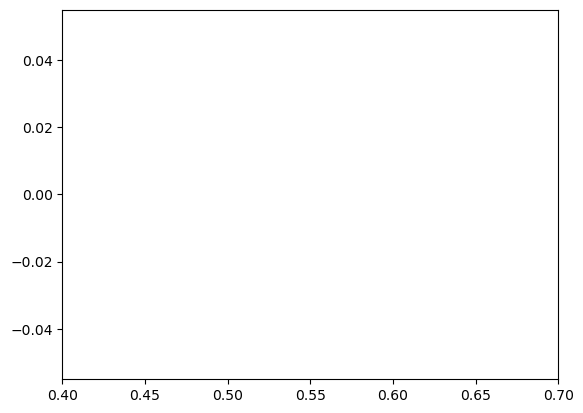

In [237]:
plt.hist(norm_dataset.ct_feas[(norm_dataset.sexs==0) & (norm_dataset.ages==age)][...,0][:,0],bins=20)
plt.xlim([0.4,0.7])


In [279]:
norm_dataset.ct_feas[(norm_dataset.sexs==0) & (norm_dataset.ages==32)].shape

(8, 62, 2)

In [297]:
import numpy as np
from scipy.stats import entropy
from sklearn.neighbors import KernelDensity
all_losses = []


for sex in range(2):
    for age in range(100):
        sample_data = np.load(f"{name}//sex-{sex}_age-{age}.npy")#[...,0]
        sample_data = sample_data.reshape((len(sample_data), -1))
        ref_data = norm_dataset.ct_feas[(norm_dataset.sexs==0) & (norm_dataset.ages==age)][...,0]
        if len(ref_data) <1:
            continue
        ref_data = ref_data.reshape((len(ref_data), -1))
        # 假设参考数据为 ref_data，采样数据为 sample_data (shape: Nx64, 512x64)
        # 逐列计算 KL 散度

        kl_divergences = []
        for col in range(ref_data.shape[1]):
            # 核密度估计 (KDE)
            kde_ref = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(ref_data[:, col].reshape(-1, 1))
            kde_sample = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(sample_data[:, col].reshape(-1, 1))
            
            # 生成测试点
            x_range = np.linspace(
                min(ref_data[:, col].min(), sample_data[:, col].min()),
                max(ref_data[:, col].max(), sample_data[:, col].max()),
                100
            ).reshape(-1, 1)
            
            # 计算概率密度
            p_ref = np.exp(kde_ref.score_samples(x_range))
            p_sample = np.exp(kde_sample.score_samples(x_range))
            
            # 避免 log(0) 错误，加一个小的平滑值
            p_ref += 1e-10
            p_sample += 1e-10
            
            # KL 散度计算
            kl_div = entropy(p_ref, p_sample)  # scipy 的 entropy 函数计算 KL 散度
            kl_divergences.append(kl_div)
        
        # print(f"KL Divergences for each column: {kl_divergences}")
        print(f"KL Divergences for each column: {np.mean(kl_divergences)}")
        all_losses.append(np.mean(kl_divergences))

KL Divergences for each column: 5.527576428823894e-05
KL Divergences for each column: 4.966477147341033e-05
KL Divergences for each column: 6.0368757342306396e-05
KL Divergences for each column: 4.0327606624749316e-05
KL Divergences for each column: 4.429200402907146e-05
KL Divergences for each column: 2.6155088484209395e-06
KL Divergences for each column: 2.4138297046822557e-06
KL Divergences for each column: 1.6297122007981456e-06
KL Divergences for each column: 1.5730769146754564e-06
KL Divergences for each column: 2.1278733122502514e-06
KL Divergences for each column: 2.219951512754394e-06
KL Divergences for each column: 4.4645577644927446e-06
KL Divergences for each column: 1.0140338692972756e-06
KL Divergences for each column: 5.36846330107034e-06
KL Divergences for each column: 2.324550292851621e-06
KL Divergences for each column: 1.2985481873733083e-06
KL Divergences for each column: 3.1008712884150634e-06
KL Divergences for each column: 3.3082191092974247e-06
KL Divergences fo

In [298]:
np.mean(all_losses)

8.186658178407212e-06

In [309]:
import numpy as np
from sklearn.manifold import TSNE
from sklearn.neighbors import KernelDensity
from scipy.stats import entropy
sex = 0
age = 21
sample_data = np.load(f"{name}//sex-{sex}_age-{age}.npy")#[...,0]
sample_data = sample_data.reshape((len(sample_data), -1))
ref_data = norm_dataset.ct_feas[(norm_dataset.sexs==0) & (norm_dataset.ages==age)][...,0]
ref_data = ref_data.reshape((len(ref_data), -1))
# 假设 ref_data 和 sample_data 是高维数据，形状为 (N, 64) 和 (512, 64)

# 1. 使用 t-SNE 将高维数据降到 2 维
tsne = TSNE(n_components=2, random_state=42, perplexity=0.01, n_iter=300)
ref_data_2d = tsne.fit_transform(ref_data)
sample_data_2d = tsne.fit_transform(sample_data)

# 2. 在降维后的空间训练 Kernel Density Estimation 模型
kde_ref = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(ref_data_2d)
kde_sample = KernelDensity(kernel='gaussian', bandwidth=0.5).fit(sample_data_2d)

# 3. 生成公共网格上的点
num_samples = 1000  # 在降维空间采样点数量
x_min, y_min = np.min(np.vstack((ref_data_2d, sample_data_2d)), axis=0)
x_max, y_max = np.max(np.vstack((ref_data_2d, sample_data_2d)), axis=0)

# 在降维后的 2D 空间中随机采样点
grid_points = np.random.uniform(low=[x_min, y_min], high=[x_max, y_max], size=(num_samples, 2))

# 4. 计算概率密度
p_ref = np.exp(kde_ref.score_samples(grid_points))  # 参考数据概率
p_sample = np.exp(kde_sample.score_samples(grid_points))  # 采样数据概率

# 避免 log(0) 错误
p_ref += 1e-10
p_sample += 1e-10

# 5. 计算 KL 散度
kl_divergence = entropy(p_ref, p_sample)
print(f"KL Divergence after t-SNE: {kl_divergence}")


KL Divergence after t-SNE: 16.204531025000666


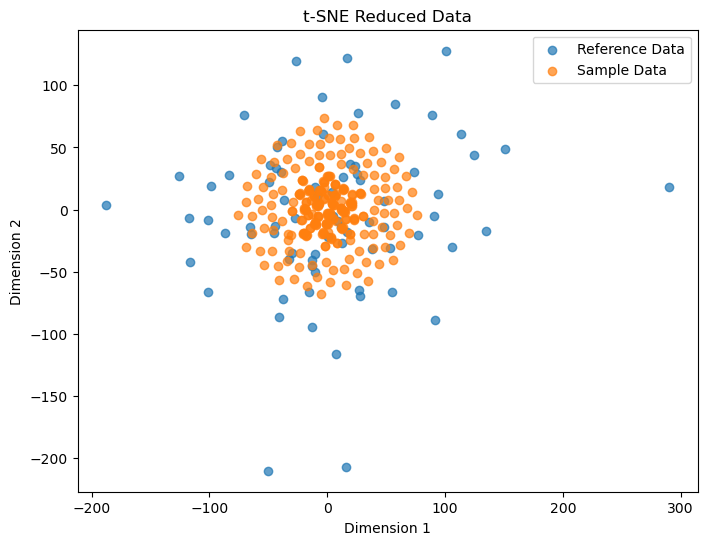

In [310]:
import matplotlib.pyplot as plt

# 绘制降维后的数据分布
plt.figure(figsize=(8, 6))
plt.scatter(ref_data_2d[:, 0], ref_data_2d[:, 1], label='Reference Data', alpha=0.7)
plt.scatter(sample_data_2d[:, 0], sample_data_2d[:, 1], label='Sample Data', alpha=0.7)
plt.legend()
plt.title('t-SNE Reduced Data')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.show()
